In [2]:
import numpy as np
import scipy.linalg
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

from general_graph_utils import *

In [24]:
G = nx.DiGraph()
G_size = 3
nodes = np.arange(1,G_size+1,step=1)
G.add_nodes_from(nodes)

G.add_edge(1,3)
G.add_edge(3,1)
G.add_edge(2,3)
G.add_edge(3,2)
G.add_edge(1,2)
G.add_edge(2,1)


G_ud = nx.Graph()
G_ud.add_node(1)
G_ud.add_node(2)
G_ud.add_node(3)
G_ud.add_edge(3, 2)
G_ud.add_edge(2, 3)
G_ud.add_edge(1, 2)
G_ud.add_edge(2, 1)
G_ud.add_edge(1, 3)
G_ud.add_edge(3, 1)

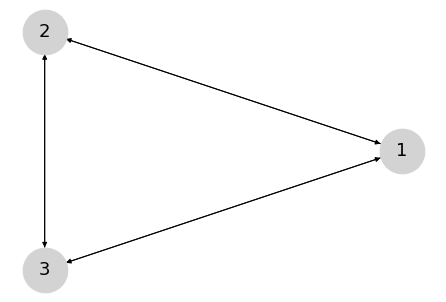

In [25]:
node_labels = {}
node_labels[1] = "1"
node_labels[2] = "2"
node_labels[3] = "3"
nx.draw(G, pos=nx.circular_layout(G), labels=node_labels, with_labels=True,node_size=2000, node_color = 'lightgray', font_size=18, font_color='black', font_family='sans-serif')

In [26]:
node_list = get_nodes(G)
num_nodes = G_size
edge_list = get_edges(G)

# not needed for 3-cycle graph but we need the data structures
cycle_list = get_cycles(G_ud)
num_cycles = len(cycle_list)

In [34]:
label_dict, label_list = get_labels(G)

In [35]:
label_dict

{(1, 3): 0.00779,
 (1, 2): 34.53633,
 (2, 3): 3.07048,
 (2, 1): 0.07601,
 (3, 1): 1.87407,
 (3, 2): 0.32744}

In [36]:
label_list

array([7.790000e-03, 3.453633e+01, 3.070480e+00, 7.601000e-02,
       1.874070e+00, 3.274400e-01])

In [37]:
L = Laplacian_all(edge_list,label_list,node_list)
pi = steady_state_spectrum(L)

In [38]:
pi

array([0.59839977, 0.03370542, 0.36789481])

How do we enforce the initial conditions we want?

* Concentrate all probability at one node
* Enforce a flux in one direction